In [ ]:
# Утилиты стандартной библиотеки
from functools import lru_cache
import os
import copy
import re
import random
import shutil
from tqdm import tqdm
from urllib.request import urlretrieve
from pathlib import Path

# Библиотеки для анализа данных
import numpy as np
import sklearn.preprocessing
from sklearn.model_selection import train_test_split

# Библиотеки для обработки изображений
import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms as T
import torch.optim as optim

import tensorflow as tf

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
sns.set()

# Библиотеки для обучения
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from skimage.morphology import dilation, footprint_rectangle

from glob import glob
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib
from skimage.measure import label, regionprops
from shapely.geometry import LineString 
from shapely import simplify
from scipy.spatial.distance import cdist  # Исправленный импорт

# Утилита для tqdm в Jupyter Notebook
from tqdm.auto import tqdm

# Определение устройства
if torch.cuda.is_available():
    device = "cuda"
elif xm.xla_device() is not None:
    device = "xla"  # TPU
else:
    device = "cpu"

print(f"Using device: {device}")

import wandb

### Часть 2. Построение графа дорожной сети 🗺️

Маски сегментации дорог, полученные в предыдущей части, сами по себе не очень удобны для анализа транспортной сети. Гораздо информативнее представить дороги в виде графа, где вершины - это перекрестки и важные точки, а ребра - участки дорог между ними. В этой части вы научитесь это делать.

#### Этапы работы

1. **Построение скелета.** Преобразуйте дороги в однопиксельные линии, сохраняя топологию. Обратите внимание на функцию `skimage.morphology.skeletonize`.

2. **Выделение узлов графа.** Для каждой точки скелета посчитайте количество соседей в окрестности $3 \times 3$: если у точки хотя бы 3 соседа, то это перекресток, если ровно 1, то тупик.

3. **Кластеризация узлов.** Скорее всего одному перекрестку будет соответствовать несколько точек, их все стоит клатеризовать в одну. Подумайте какой из алгоритмов кластеризации лучше всего подойдет в данной задаче, обоснуйте свой выбор алгоритма и его параметров.

4. **Преобразование скелета в набор линий**
    - Удалите перекрестки из скелета.
    - Выделите компоненты связности оставшихся точек. Поскольку перекрестки удалены, то одной компонентой будет являться участок дороги, соединяющий два соседних перекретка. Обратите внимание на функции `skimage.measure.label` и `skimage.measure.regionprops`.
    - Преобразуйте каждую компоненту в простую линию. Обратите внимание на `shapely.geometry.LineString` и `shapely.simplify`.

5. **Построение графа.** Для пары крайних точек каждой из полученных линий в пункте 4 найдите ближайшие среди выделенных в пункте 3 узлов, это и будут соседние вершины в графе дорожной сети.
    
6. **Визуализация.** Наложите полученный граф на исходный спутниковый снимок и на маску сегментации. Убедитесь, что большинство дорог удалось корректно отразить в графе.

*Советы*
- Визуализируйте промежуточные результаты на каждом шаге.
- В этой части разрешается и даже рекомендуется использовать LLM как для более глубокого понимания, так и для генерации кода. Кстати, описанный выше пайплайн почти полностью предложен deepseek.


1) Построение скелета.

In [ ]:
skeletons_masks = skeletonize(np.array([dilation(mask, footprint_rectangle((3, 3))) for mask in predicted_masks]))

In [ ]:
def display_mask(mask, figsize=(6, 6), cmap='gray'):
    """
    Визуализация одной маски.
    
    Args:
        mask (np.ndarray): Маска для отображения.
        figsize (tuple): Размеры фигуры для отображения.
        cmap (str): Колormap для отображения.
    
    Returns:
        None
    """
    plt.figure(figsize=figsize)
    plt.imshow(mask, cmap=cmap)
    plt.title("Mask")
    plt.axis('off')  # Убираем оси
    plt.show()

In [ ]:
def display_random_skeleton_masks(skeletons_masks, num_random=5, figsize=(15, 5), cmap='gray'):
    random_indices = np.random.choice(skeletons_masks.shape[0], num_random, replace=False)

    # Визуализируем случайные маски
    fig, ax = plt.subplots(1, num_random, figsize=figsize)
    
    for i, idx in enumerate(random_indices):
        ax[i].imshow(skeletons_masks[idx], cmap=cmap)
        ax[i].set_title(f"Mask {idx+1}")
        ax[i].axis('off')

    plt.show()

Посмотрим на результат скелетизации

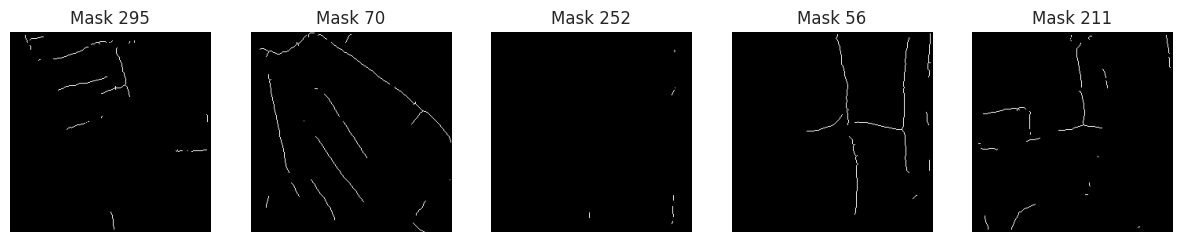

In [ ]:
display_random_skeleton_masks(skeletons_masks)

2) Выделение узлов графов.

Наболее удобный алгоритм кластерицазии -- DBSCAN в нем как раз можно настроить радиус, где искать точки перекрестка, и сколько точек нужно, что отнести кластер к перекрестку.

In [ ]:
def extract_nodes_from_mask(skeleton_mask):
    """
    Извлекает узлы (перекрестки и тупики) из скелета маски.
    
    Args:
        mask (np.ndarray): скелетная Бинарная маска.
        
    Returns:
        nodes (list): Список координат узлов.
        node_types (list): Список типов узлов (1 - перекресток, 0 - тупик).
    """
    nodes = []
    node_types = []
    
    # Проходим по всем пикселям скелета
    for i in range(1, skeleton_mask.shape[0] - 1):
        for j in range(1, skeleton_mask.shape[1] - 1):
            if skeleton_mask[i, j]:
                # Считаем количество соседей в окрестности 3x3
                neighborhood = skeleton_mask[i-1:i+2, j-1:j+2]
                num_neighbors = np.sum(neighborhood) - 1  # Исключаем саму точку
                if num_neighbors == 1:  # Тупик
                    nodes.append((i, j))
                    node_types.append(0)
                elif num_neighbors >= 3:  # Перекресток
                    nodes.append((i, j))
                    node_types.append(1)
    
    return nodes, node_types

# Функция кластеризации узлов с использованием DBSCAN
def cluster_nodes(nodes, eps=3, min_samples=3):
    """
    Кластеризация узлов с использованием DBSCAN.
    
    Args:
        nodes (list): Список координат узлов (перекрестков и тупиков).
        eps (float): Радиус, в пределах которого точки будут объединяться в кластер.
        min_samples (int): Минимальное количество точек для формирования кластера.
    
    Returns:
        labels (np.ndarray): Метки кластеров для каждой точки. -1 означает шум.
    """
    if len(nodes) == 0:
        return []
    nodes_array = np.array(nodes)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(nodes_array)
    
    return labels

def visualize_clusters_on_original_mask(original_mask, nodes, labels, node_types, radius=2):
    """
    Визуализация кластеров узлов на исходной бинарной маске.
    
    Args:
        original_mask (np.ndarray): Исходная бинарная маска.
        nodes (list): Список координат узлов.
        labels (np.ndarray): Метки кластеров для каждой точки. -1 означает шум.
        node_types (list): Список типов узлов (1 - перекресток, 0 - тупик).
        radius (int): Радиус вокруг узла для отображения цвета.
    
    Returns:
        None
    """
    # Переводим бинарную маску в RGB-формат
    rgb_mask = np.stack([original_mask] * 3, axis=-1)  # [H, W, 3]
    rgb_mask = (rgb_mask * 255).astype(np.uint8)

    # Создаем копию для наложения цветов
    overlay_mask = np.copy(rgb_mask)
    
    # Устанавливаем фиксированные цвета для всех типов:
    # Черный (0) – ничего
    # Белый (1) – дорога
    # Красный (2) – перекресток
    # Зеленый (3) – тупик
    color_map = {
        0: np.array([0, 0, 0], dtype=np.uint8),    # Черный
        1: np.array([255, 255, 255], dtype=np.uint8),  # Белый
        2: np.array([255, 0, 0], dtype=np.uint8),    # Красный (перекресток)
        3: np.array([0, 255, 0], dtype=np.uint8)     # Зеленый (тупик)
    }

    for idx, (node, label, node_type) in enumerate(zip(nodes, labels, node_types)):
        i, j = node
        if label != -1:  # Если узел не шум
            # Определяем цвет в зависимости от типа узла
            if node_type == 1:
                # Перекресток – красный
                color = color_map[2]
            elif node_type == 0:
                # Тупик – зеленый
                color = color_map[3]
            else:
                color = color_map[1]  # Если не перекресток и не тупик, то дорога (белый)
            
            # Отображаем узел "пожирнее" — закрашиваем круг радиуса radius
            for di in range(-radius, radius + 1):
                for dj in range(-radius, radius + 1):
                    # Проверяем, чтобы точка находилась внутри круга
                    if di**2 + dj**2 <= radius**2:
                        ni, nj = i + di, j + dj
                        # Проверяем границы изображения
                        if 0 <= ni < overlay_mask.shape[0] and 0 <= nj < overlay_mask.shape[1]:
                            overlay_mask[ni, nj] = color

    # Отображаем изображение с наложенными цветами
    plt.imshow(overlay_mask)
    plt.title("Visualizing Clusters on the Original Mask (Thicker Nodes)")
    plt.axis('off')
    plt.show()

Отобразим нашу кластеризацию.

Зеленый -- тупик

Красный -- перекресток

152


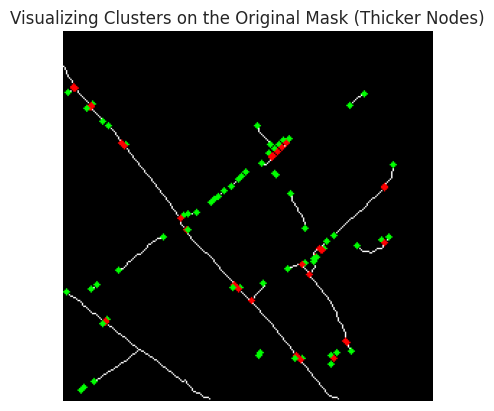

In [ ]:
index = np.random.choice(skeletons_masks.shape[0])
print(index)
random_mask = skeletons_masks[416]
nodes, node_types = extract_nodes_from_mask(random_mask)
labels = cluster_nodes(nodes, eps=20, min_samples=2)
visualize_clusters_on_original_mask(random_mask, nodes, labels, node_types)

4) Преобразуем скелет в набор линий 

Удалим перекрестки

In [ ]:
def remove_crossroads(skeleton_mask, nodes, node_types, labels):
    """
    Удаляет узлы-перекрестки из маски.

    Args:
        skeleton_mask (np.ndarray): Исходная маска (бинарная или с цветами).
        nodes (list): Список координат узлов (i, j).
        node_types (list): Список типов узлов (1 - перекресток, 0 - тупик).
        labels (np.ndarray): Метки кластеров для узлов.
    
    Returns:
        np.ndarray: Маска без перекрестков.
    """
    updated_mask = np.copy(skeleton_mask)
    updated_mask[[node[0] for node, node_type in zip(nodes, node_types) if node_type == 1], 
                 [node[1] for node, node_type in zip(nodes, node_types) if node_type == 1]] = 0
    return updated_mask


def remove_crossroads_from_array(skeletons_masks, eps=4, min_samples=3):
    updated_masks = []
    
    for skeleton_mask in skeletons_masks:
        nodes, node_types = extract_nodes_from_mask(skeleton_mask)
        labels = cluster_nodes(nodes, eps=eps, min_samples=min_samples)
        
        updated_mask = remove_crossroads(skeleton_mask, nodes, node_types, labels)
        updated_masks.append(updated_mask)
    return updated_masks

In [ ]:
updated_masks = remove_crossroads_from_array(skeletons_masks, 20, 6)

Убедимся, что перекрестки удалены.

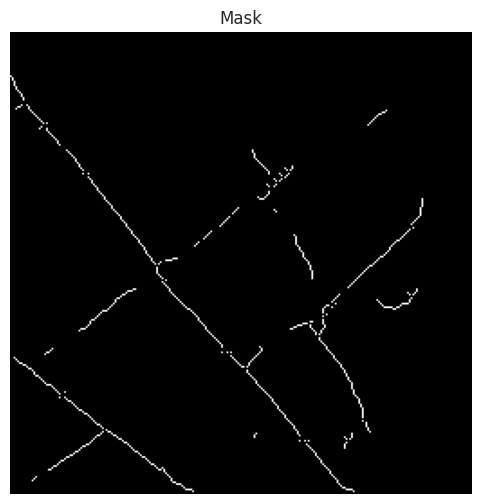

In [ ]:
display_mask(updated_masks[416])

Выделим компоненты связности

In [ ]:
def get_lines_from_mask(mask):
    """
    Извлекает линии из маски с использованием regionprops.
    
    Args:
        mask (np.ndarray): Маска (бинарная).
        
    Returns:
        list: Список объектов LineString для каждой линии.
    """
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    lines = []
    
    # Пробежимся по регионам и создадим линии
    for region in regions:
        coords = region.coords
        
        if len(coords) > 1:
            # Создаем LineString для каждого региона
            line = LineString([tuple(coord) for coord in coords])
            lines.append(line)
    
    return lines

def visualize_mask_and_lines(mask, lines):
    """
    Визуализирует маску и линии на ней.
    
    Args:
        mask (np.ndarray): Маска (бинарная).
        lines (list): Список объектов LineString для отображения.
    """
    plt.imshow(mask, cmap='gray')
    for line in lines:
        # Отображаем линии на маске
        x, y = line.xy
        plt.plot(y, x, color='r', linewidth=2)
    plt.show()

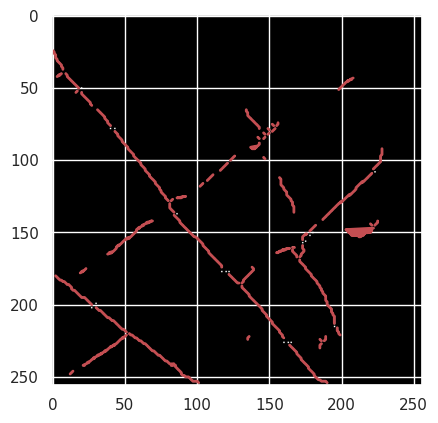

In [ ]:
index = 416
mask = updated_masks[index]

lines = get_lines_from_mask(mask)
visualize_mask_and_lines(mask, lines)

Теперь построим дороги между ближайшими соседями

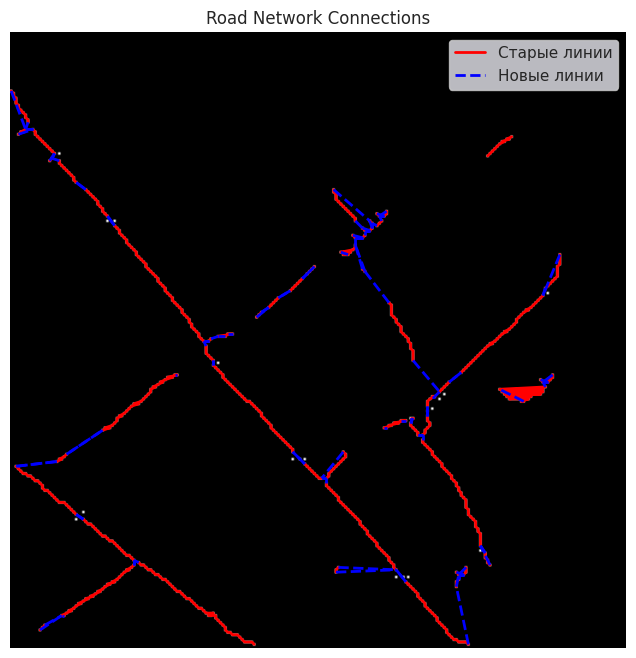

In [ ]:
def find_nearest_lines(line, nodes, threshold=40):
    """
    Находит ближайшие узлы к концам линии, исключая собственные конечные точки
    
    Args:
        line (LineString): Исходная линия
        nodes (np.array): Массив координат узлов [N, 2]
        threshold (float): Максимальное допустимое расстояние
    
    Returns:
        tuple: Две ближайшие точки (или None если не найдены)
    """
    # Получаем начальную и конечную точки линии
    start = np.array(line.coords[0])
    end = np.array(line.coords[-1])
    
    # Вычисляем расстояния до всех узлов
    start_dists = cdist([start], nodes)[0]
    end_dists = cdist([end], nodes)[0]
    
    # Исключаем точки самой линии
    valid_nodes = [
        n for n in nodes 
        if not np.array_equal(n, start) and not np.array_equal(n, end)
    ]
    
    if len(valid_nodes) == 0:
        return None, None
    
    # Находим ближайшие точки
    start_nearest_idx = np.argmin(cdist([start], valid_nodes)[0])
    end_nearest_idx = np.argmin(cdist([end], valid_nodes)[0])
    
    start_nearest = valid_nodes[start_nearest_idx]
    end_nearest = valid_nodes[end_nearest_idx]
    
    # Проверка порогового расстояния
    if np.linalg.norm(start - start_nearest) > threshold:
        start_nearest = None
        
    if np.linalg.norm(end - end_nearest) > threshold:
        end_nearest = None
    
    return start_nearest, end_nearest

def create_connection_lines(lines, nodes):
    """
    Создает линии соединений между концами линий и ближайшими узлами
    """
    new_lines = []
    for line in lines:
        start_conn, end_conn = find_nearest_lines(line, nodes)
        
        if start_conn is not None:
            new_lines.append(LineString([line.coords[0], start_conn]))
            
        if end_conn is not None:
            new_lines.append(LineString([line.coords[-1], end_conn]))
    
    return new_lines

# Визуализация
def plot_results(mask, lines, new_lines):
    plt.figure(figsize=(8, 8))
    
    # Отображаем исходную маску
    plt.imshow(mask, cmap='gray')
    
    # Рисуем исходные линии
    for line in lines:
        x, y = line.xy
        plt.plot(y, x, c='red', linewidth=2, label='Старые линии' if 'Старые линии' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Рисуем новые соединения
    for line in new_lines:
        x, y = line.xy
        plt.plot(y, x, c='blue', linewidth=2, linestyle='--', label='Новые линии' if 'Новые линии' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Добавляем легенду (только два элемента: для старых и новых линий)
    plt.legend(loc='upper right')
    
    # Настройка отображения
    plt.title("Road Network Connections")
    plt.axis('off')
    plt.show()
    
lines = get_lines_from_mask(mask)
nodes, node_types = extract_nodes_from_mask(mask)
new_lines = create_connection_lines(lines, nodes)

plot_results(mask, lines, new_lines)

In [ ]:
def create_new_mask(lines, new_lines, shape=(256, 256)):
    # Создаём пустую маску
    new_mask = np.zeros(shape, dtype=np.uint8)
    
    # Функция для рисования линий на маске
    def draw_lines(mask, lines, value):
        for line in lines:
            x, y = np.round(line.xy).astype(int)
            for i in range(len(x) - 1):
                cv2.line(mask, (y[i], x[i]), (y[i + 1], x[i + 1]), color=value, thickness=3)

    draw_lines(new_mask, lines, 1)
    draw_lines(new_mask, new_lines, 1)
    
    return new_mask

Наконец проделаем это со всеми масками

In [ ]:
graph_masks = []

for i, mask in tqdm(enumerate(updated_masks)):     #437 масок
    lines = get_lines_from_mask(mask)
    nodes, node_types = extract_nodes_from_mask(mask)
    new_lines = create_connection_lines(lines, nodes)
    new_mask = create_new_mask(lines, new_lines)
    graph_masks.append(new_mask)

0it [00:00, ?it/s]

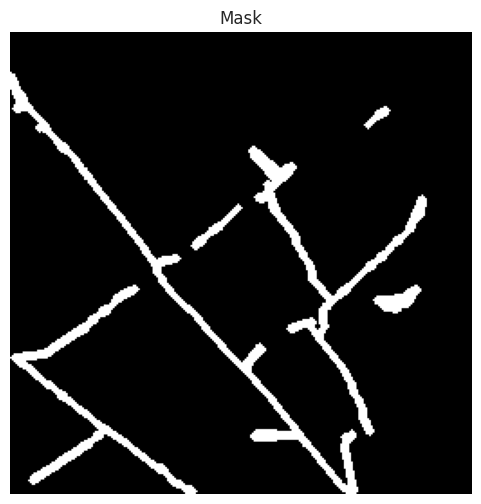

In [ ]:
index = 416
display_mask(graph_masks[index])

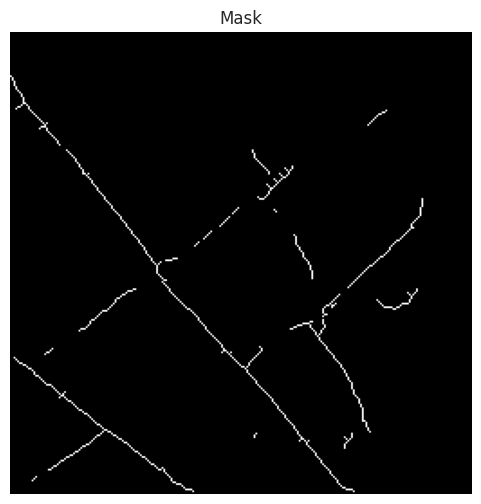

In [ ]:
display_mask(skeletons_masks[index])

Сохраним полученные маски

In [ ]:
def save_masks(masks, output_dir, image_paths):
    """
    Сохраняет предсказанные маски с правильными именами.

    :param masks: список numpy-массивов (предсказанных масок)
    :param output_dir: директория для сохранения масок
    :param image_paths: список путей к исходным изображениям, откуда берутся координаты
    """
    os.makedirs(output_dir, exist_ok=True)

    tile_pattern = re.compile(r'_(\d+)_(\d+)\.jpg$')

    for mask, img_path in zip(masks, image_paths):
        match = tile_pattern.search(img_path)
        if match:
            x, y = match.groups()
        else:
            raise ValueError(f"Ошибка разбора имени файла: {img_path}")

        # Сохраняем маску как изображение
        mask_img = Image.fromarray((mask * 255).astype(np.uint8))
        mask_img.save(os.path.join(output_dir, f"mask_{x}_{y}.jpg"))

    print(f"Сохранено {len(masks)} масок в {output_dir}/")

In [ ]:
graph_paths = [f"graph_{x}_{y}.jpg" for x in range(19) for y in range(23)]

In [ ]:
save_masks(graph_masks, output_dir="/kaggle/working/graph_masks", image_paths=graph_paths)

Сохранено 437 масок в /kaggle/working/graph_masks/


In [ ]:
stitch_tiles(output_folder="/kaggle/working/graph_masks",
             output_path='/kaggle/working/graph_dolgopa.jpg')

The image has been stitched and saved successfully at /kaggle/working/graph_dolgopa.jpg.


Посмотрим на улучшенное изображение транспортной сети.

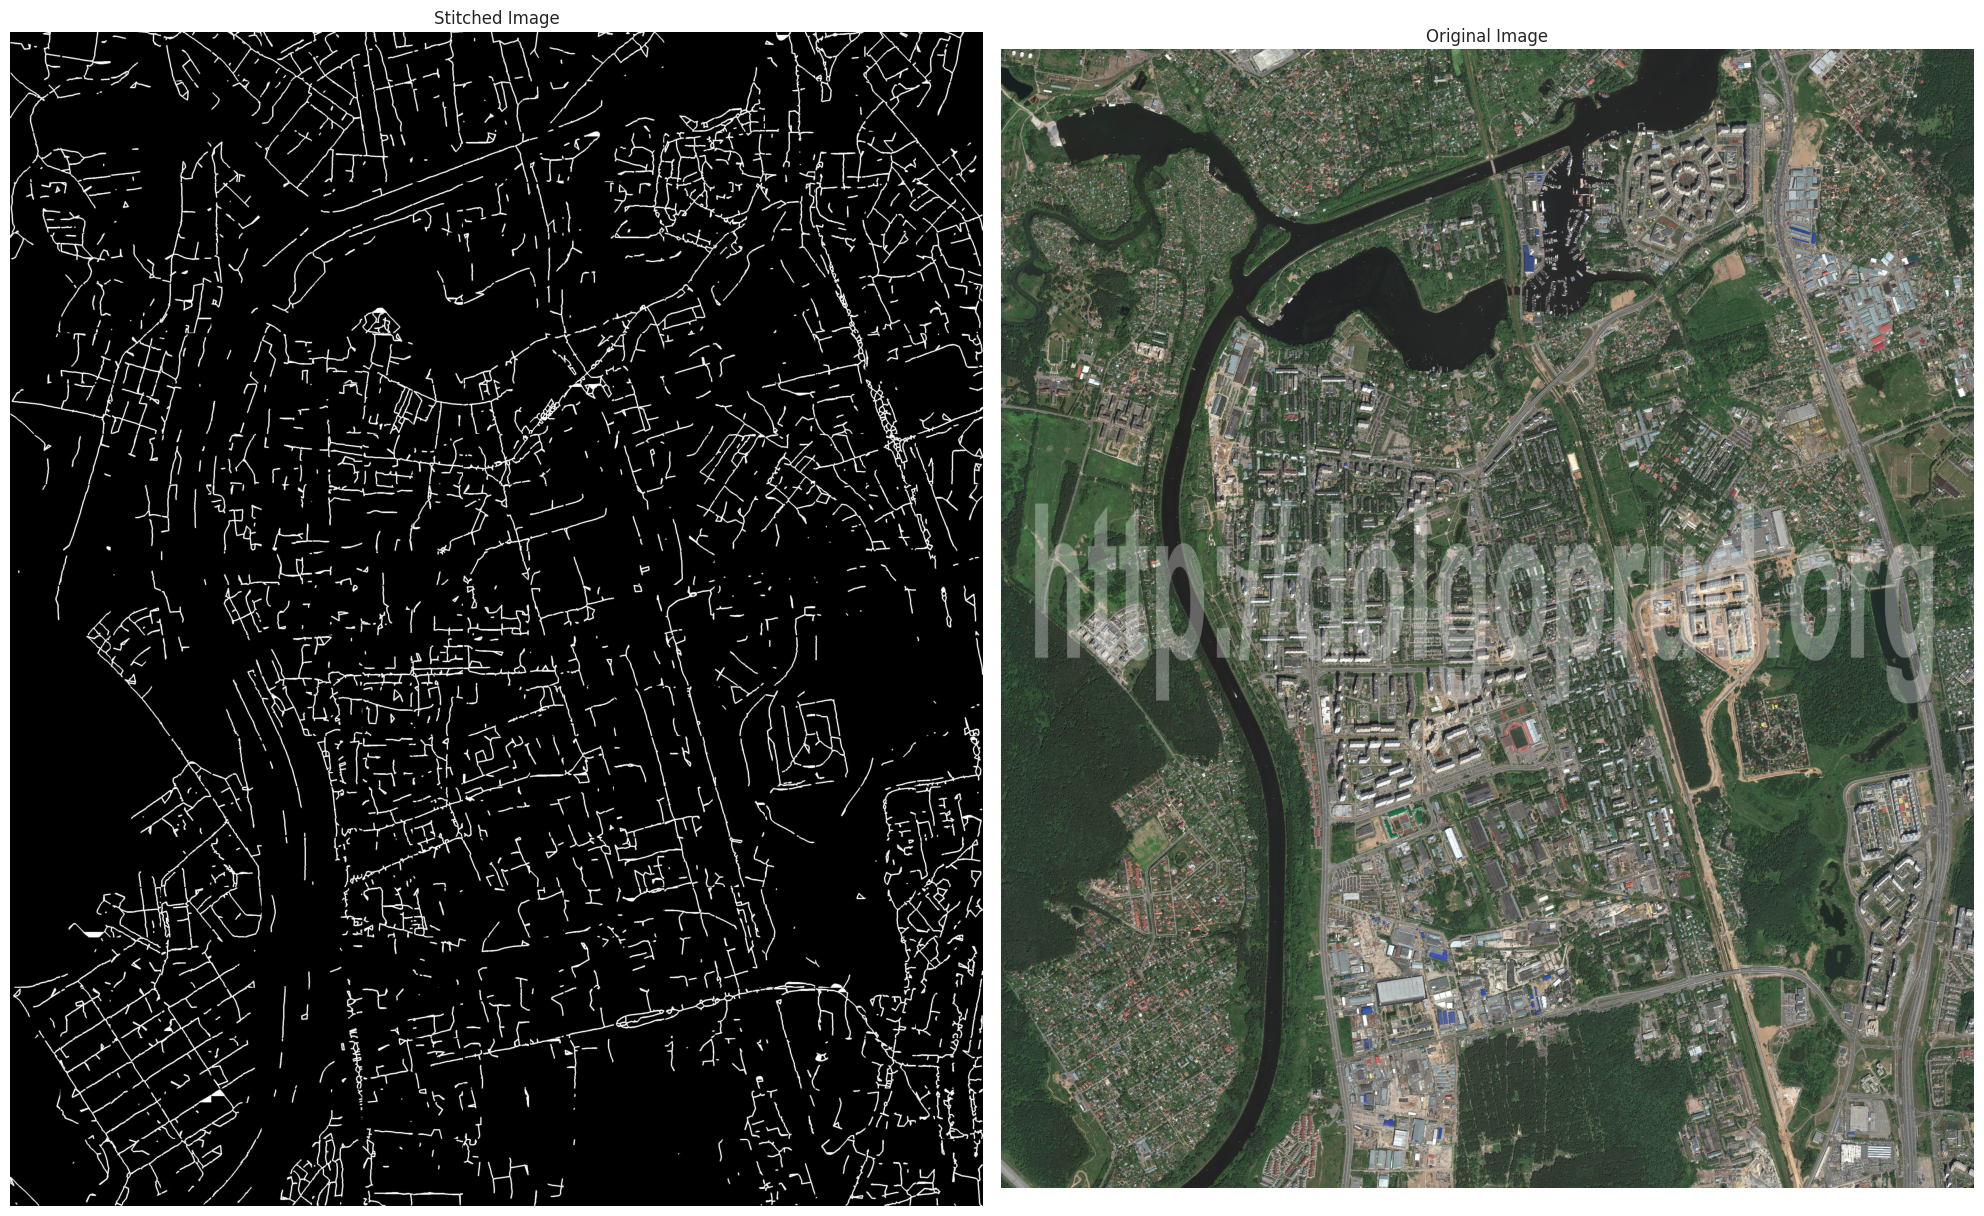

In [ ]:
img1 = Image.open("/kaggle/working/graph_dolgopa.jpg")
img2 = Image.open("/kaggle/input/dolgopa/dolgoprudny.jpg")

fig, axes = plt.subplots(1, 2, figsize=(20, 15))

# Отображаем первое изображение
axes[0].imshow(img1)
axes[0].set_title("Stitched Image")
axes[0].axis("off")

# Отображаем второе изображение
axes[1].imshow(img2)
axes[1].set_title("Original Image")
axes[1].axis("off")

# Показываем результат
plt.tight_layout()
plt.show()

**Выводы**

Получилось соединить некоторые дороги, котоыре сеть не смогла до конца распознать. 

Но вместе с тем выявилась другая проблема, при построении скелета сети, при применении функции skelitinize мы теряем очень много информации, а большие дороги распознаются как веретено(то есть как множество малекньких дорог), в связи с чем полученный результат не очень хорош